## Imports

In [ ]:
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install gdown
!pip install retina-face

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-y_hsalso
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-y_hsalso
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import argparse
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import gdown
from keras_vggface.utils import preprocess_input
import re
import keras
from keras_vggface.vggface import VGGFace
from google.colab.patches import cv2_imshow
from retinaface import RetinaFace
from retinaface.commons import preprocess, postprocess
import urllib.request
import tarfile
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import zipfile
import math
from keras_vggface.vggface import VGGFace
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Concatenate, Layer, Reshape, Lambda, Dropout
from keras.optimizers import Adam

## Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [ ]:
base_path = '/content/Drive/MyDrive/EE443/FaceRec/'

# Retrieves a file name from FaceRec as a numpy array.
# if em is true, fetches an embedding, if false, fetches face
def file_fetch(em, file_name):
  if em:
    path = base_path + 'Embeddings/' + file_name + '.npy'
  else:
    path = base_path + 'Faces/' + file_name + '.npy'

  array_file = np.load(path)
  return array_file

# Writes given data to FaceRec as npy file
def file_write(em, file_name, data):
  if em:
    path = base_path + 'Embeddings/' + file_name + '.npy'
  else:
    path = base_path + 'Faces/' + file_name + '.npy'

  np.save(path, data)

In [ ]:
## Training data

# URL of the LFW dataset tar file
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
# Destination path to save the downloaded tar file
save_path = '/content/lfw.tgz'
# Destination directory to extract the dataset
extract_dir = '/content/lfwData/'

# Download the LFW dataset tar file
urllib.request.urlretrieve(lfw_url, save_path)

# Extract the dataset from the tar file
with tarfile.open(save_path, 'r:gz') as tar:
    tar.extractall(extract_dir)

# Check the contents of the extracted directory
print(os.listdir(extract_dir))

# Does the same for the text file of names
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-names.txt'
save_path = '/content/lfwNames.txt'

urllib.request.urlretrieve(lfw_url, save_path)

['lfw']


('/content/lfwNames.txt', <http.client.HTTPMessage at 0x7f1680ed4e20>)

In [ ]:
# Validation data
!gdown --fuzzy https://drive.google.com/file/d/1tUKri0ObB6c9ODCGE0Ks_xm9Lr4mcvyp/view?usp=share_link --output val.zip
!unzip -q val.zip -d val

Downloading...
From: https://drive.google.com/uc?id=1tUKri0ObB6c9ODCGE0Ks_xm9Lr4mcvyp
To: /content/val.zip
100% 1.86M/1.86M [00:00<00:00, 132MB/s]
replace val/val.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Testing data
!gdown --fuzzy https://drive.google.com/file/d/1CgYs86z9YB2yvCdLq9ra1v4RTX8T7ijT/view?usp=share_link --output test.zip
!unzip -q test.zip > /dev/null

In [ ]:
# Creates an array of image paths and corresponding name labels
dataset_folder = '/content/lfwData/lfw'

image_paths = []
names_list = []

# Iterates through each folder containing each image of one person
for item in os.listdir(dataset_folder):
    item_path = os.path.join(dataset_folder, item)
    # Iterates through each image in the folder and appends the path and person's name (which is item) to the lists
    for image in os.listdir(item_path):
        image_paths.append(os.path.join(item_path, image))
        names_list.append(item)

print(image_paths[0:5])
print(names_list[0:5])

['/content/lfwData/lfw/Eva_Marie_Saint/Eva_Marie_Saint_0001.jpg', '/content/lfwData/lfw/Roberto_Arguelles/Roberto_Arguelles_0001.jpg', '/content/lfwData/lfw/Jelena_Dokic/Jelena_Dokic_0001.jpg', '/content/lfwData/lfw/Jelena_Dokic/Jelena_Dokic_0002.jpg', '/content/lfwData/lfw/Jelena_Dokic/Jelena_Dokic_0005.jpg']
['Eva_Marie_Saint', 'Roberto_Arguelles', 'Jelena_Dokic', 'Jelena_Dokic', 'Jelena_Dokic']


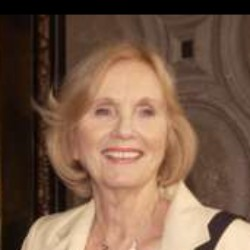

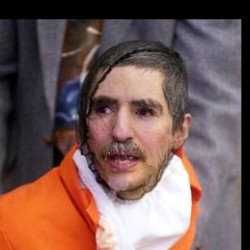

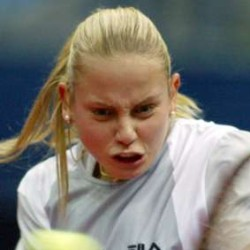

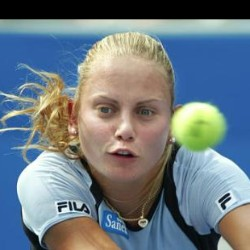

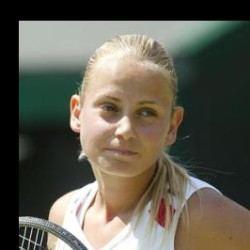

In [ ]:
# Test if images were loaded correctly
num_examples = 5
print(len(image_paths))

# prints 5 test images
for i in range(num_examples):
    example_image = cv2.imread(image_paths[i])
    cv2_imshow(example_image)


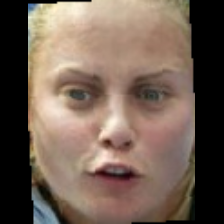

In [ ]:
# Width padding function so that image ratios are maintained through resizing. See below example output.
# Assumes that a face will be taller than it is wide
def pad_image(image, target_width, target_height):
    height, width = image.shape[:2]

    if width >= target_width:
        return image  # No need to pad if the width is larger or equal to the target width

    # Calulates the new width after scaling the height to be the target height. Scales the width by proportionally the same amount as height. 
    resize_width = int(width * (target_height/height))

    # Resize the image to the calculated target height while preserving aspect ratio
    resized_image = cv2.resize(image, (resize_width, target_height))

    height, width = resized_image.shape[:2]

    # Calculates left and right pad size
    pad_width = max(target_width - width, 0) # Ensures pad_width is not negative
    left = pad_width // 2
    right = pad_width - left

    # Applies padding to the image
    padded_image = cv2.copyMakeBorder(resized_image, 0, 0, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    return padded_image

# Will create a 224x224 (the size vggface wants) image of just the persons face. Will pad with black space to maintain aspect ratio
# Padding inspired by this approach: https://github.com/serengil/deepface
# RetinaFace source: https://sefiks.com/2021/04/27/deep-face-detection-with-retinaface-in-python/
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    faces = RetinaFace.detect_faces(image_path)

    preprocessed_faces = []

    if (len(faces) == 0):
        print("No faces detected in ", image_path)
    else:
        face_choice = 'face_1'
        # Chooses the face where the nose is closest to the center of the image to make sure the program grabs the focused-on face
        if(len(faces) > 1):
            # Calculates center of image
            height, width = img.shape[:2]
            center = [width/2, height/2]
            shortest_dist = math.sqrt((width - center[0]) ** 2 + (height - center[1]) ** 2)
            # Iterates through each face to choose best one
            for face_key, face_value in faces.items():
                landmarks = face_value['landmarks']
                nose_coordinates = landmarks['nose']
                dist = math.sqrt((nose_coordinates[0] - center[0]) ** 2 + (nose_coordinates[1] - center[1]) ** 2)
                if (dist < shortest_dist):
                    shortest_dist = dist
                    face_choice = face_key

        facial_area = faces[face_choice]['facial_area']
        right_eye = faces[face_choice]['landmarks']['right_eye']
        left_eye = faces[face_choice]['landmarks']['left_eye']
        nose = faces[face_choice]['landmarks']['nose']
        x, y, width, height = facial_area[0], facial_area[1], facial_area[2] - facial_area[0], facial_area[3] - facial_area[1]
        face_img = img[y:y+height, x:x+width]

        face_img = postprocess.alignment_procedure(face_img, right_eye, left_eye, nose)
        face_img = pad_image(face_img, 224, 224) # Adds black padding on either side of face
        face_img = cv2.resize(face_img, (224, 224)) # makes sure image is correct size
        preprocessed_faces = face_img
    return np.array(preprocessed_faces)
face_example_img = preprocess_image(image_paths[3])
cv2_imshow(face_example_img)

# Now ready to preprocess all images

In [ ]:
## CAUTION! WILL TAKE A LONG TIME TO RUN
## Don't run if you can load the processed images with file_fetch
# Will preprocess all of the images and save them to a separate file.

processed_images = []
processed_labels = []
# Iterates through each file path
for i in range(len(image_paths)):
    face = preprocess_image(image_paths[i])
    # if output from preprocess_image is size 0, meaning no faces, print error
    if (face.size == 0):
        print("Error: no faces found in ", image_paths[i])
    else:
        # Add face image and label to the list if the detector detects at least 1 face
        processed_images.append(face)
        processed_labels.append(names_list[i])

file_write(False, 'processedImages', processed_images)
file_write(False, 'processedLabels', processed_labels)


KeyboardInterrupt: ignored

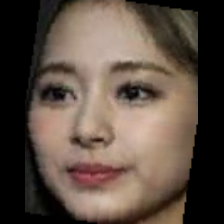

In [ ]:
# Process validation data
# Takes the folder path the validation pairs are saved in and creates an image pair array and a labels array
def load_validation_data(val_folder):
    val_pairs = []
    val_pair_labels = []
    val_txt_path = os.path.join(val_folder, 'val.txt')
    with open(val_txt_path, 'r') as file:
        lines = file.readlines()[1:]  # Skip the header line
        for line in lines:
            pair_id, label = line.strip().split(',')
            pair_id = pair_id.zfill(3)  # Pad the pair ID with zeros
            image_path_1 = os.path.join(val_folder, 'val', 'val_{}_0.jpg'.format(pair_id))
            image_path_2 = os.path.join(val_folder, 'val', 'val_{}_1.jpg'.format(pair_id))

            # Preprocess the pair images
            image_1 = preprocess_image(image_path_1)
            image_2 = preprocess_image(image_path_2)

            # Append the pair and label to the validation data
            val_pairs.append([image_1, image_2])
            val_pair_labels.append(int(label))

    return np.array(val_pairs), np.array(val_pair_labels)

with zipfile.ZipFile('val.zip', 'r') as zip_ref:
    zip_ref.extractall('val_folder')

# Load the validation data
val_folder = 'val'
val_pairs, val_pair_labels = load_validation_data(val_folder)

cv2_imshow(val_pairs[0, 0])

# Optional save function:
#file_write(False, 'processedValImages', val_pairs)
#file_write(False, 'processedValLabels', val_pair_labels)

In [ ]:
# Loads the test data from a given folder path, but makes only an array of image pairs without a labels array
def load_test_data(test_folder): 
    test_pairs = []
    for i in range(400):
        pair_id = str(i).zfill(3)
        image_path_1 = os.path.join(test_folder, 'test', 'test_{}_0.jpg'.format(pair_id))
        image_path_2 = os.path.join(test_folder, 'test', 'test_{}_1.jpg'.format(pair_id))

        # Preprocess the pair images
        image_1 = preprocess_image(image_path_1)
        image_2 = preprocess_image(image_path_2)

        test_pairs.append([image_1, image_2])
    return np.array(test_pairs)

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('test_folder')

test_folder = 'test_folder'
test_pairs = load_test_data(test_folder)

Example 1


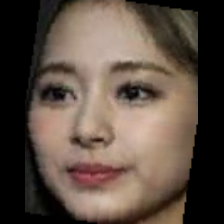

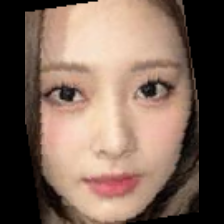

Label: 1

Example 2


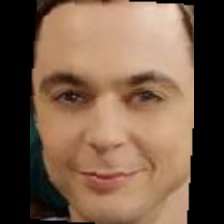

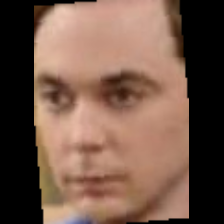

Label: 1

Example 3


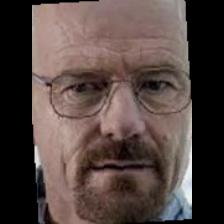

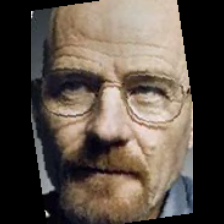

Label: 1



In [ ]:
# Print a few examples
num_examples = 3
for i in range(num_examples):
    print("Example", i+1)
    cv2_imshow(val_pairs[i][0])
    cv2_imshow(val_pairs[i][1])
    print("Label:", val_pair_labels[i])
    print()

In [ ]:
## Uncomment and run to load the preprocessed data instead of regenerating it if you have it saved already:

#processed_images = file_fetch(False, 'processedImages')
#processed_labels = file_fetch(False, 'processedLabels')

In [ ]:
# Basic Resnet50 model from the VGGFace package
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg') 
# Description here: https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/

# Function to use VGGFace to make a predictions on the inputted array of faces
# can take any number of faces and returns an array with embeddings for each one
def vggFacePredsSingles(face_images, model):
    faces = np.asarray(face_images, 'float32') # Cast to float
    faces = preprocess_input(faces, version=2) # Version 2 for the Resnet50 model. Usage described here: https://github.com/rcmalli/keras-vggface
    preds = model.predict(faces)
    return preds

# Same function but for pairs
def vggFacePredsDoubles(face_pairs, model):
    preds1 = vggFacePredsSingles(face_pairs[:, 0], model)
    preds2 = vggFacePredsSingles(face_pairs[:, 1], model)
    preds = []
    for i in range(len(preds1)):
        preds.append(verify(preds1[i], preds2[i]))
    return np.array(preds)


In [ ]:
## Test code for embeddings:

example_images = []
example_labels = []
# Iterates through each file path
for i in range(len(image_paths[0:20])):
    face = preprocess_image(image_paths[i])
    # if output from preprocess_image is size 0, meaning no faces, print error
    if (face.size == 0):
        print("Error: no faces found in ", image_paths[i])
    else:
        # Add face image and label to the list if the detector detects at least 1 face
        example_images.append(face)
        example_labels.append(names_list[i])

preds = vggFacePredsSingles(example_images, model)
print(preds)
print(example_labels)

1/1 [==============================] - 1s 792ms/step
[[0.07950325 7.9410057  0.8479067  ... 2.7443922  0.         0.11806066]
 [0.34384853 0.11005139 2.7091289  ... 0.         0.3474093  0.        ]
 [0.         4.4580736  1.2792847  ... 0.         2.8844566  0.10836226]
 ...
 [0.         0.         3.6041508  ... 0.19447139 0.04610468 0.        ]
 [0.         0.         1.6873257  ... 6.6598     0.         1.6492815 ]
 [0.07491015 0.         0.29158822 ... 2.4838803  0.         0.        ]]
['Eva_Marie_Saint', 'Roberto_Arguelles', 'Jelena_Dokic', 'Jelena_Dokic', 'Jelena_Dokic', 'Jelena_Dokic', 'Jelena_Dokic', 'Jelena_Dokic', 'Jelena_Dokic', 'Jelena_Dokic', 'Wen_Ho_Lee', 'Jose_Luis_Chilavert', 'Clive_Lloyd', 'Carlos_Salinas', 'Luis_Figo', 'Luis_Figo', 'Luis_Figo', 'Luis_Figo', 'Jason_Clermont', 'Eugene_Teslovic']


In [ ]:
# Compare two embeddings and determine if the faces are from the same person
# Returns true if the faces are from the same person
def verify(embedding1, embedding2, cutoff=0.5):
    embedding1 = np.array(embedding1)
    embedding2 = np.array(embedding2)
    # Calculates cosine distance between embeddings. Will be between 0 and 1.
    # 0 is most similar, 1 is least similar
    distance = cosine_distances(embedding1.reshape(1, -1), embedding2.reshape(1, -1))
    if distance <= cutoff:
        return 1
    return 0

print(verify(preds[6], preds[7]))
print(verify(preds[6], preds[10]))
print(verify(preds[1], preds[1]))
print(verify(preds[3], preds[15]))

0
0
1
0


In [ ]:
# Preprocess each image for VGGFace Resnet50 in an array of image pairs
def preprocess_image_pairs(image_pairs):
    # Iterate over each image pair
    for i in range(len(image_pairs)):
        image_pairs[i, 0] = preprocess_input(np.asarray(image_pairs[i, 0], 'float32'), version=2)
        image_pairs[i, 1] = preprocess_input(np.asarray(image_pairs[i, 1], 'float32'), version=2)

    return image_pairs

In [ ]:
# Generate pairs for the training images from a list of processed face images
def generate_pairs(processed_images, processed_labels):
    processed_images = np.array(processed_images)
    processed_labels = np.array(processed_labels)
    pairs = []
    pair_labels = []
    unique_labels = np.unique(processed_labels)

    for label in unique_labels:
        label_indices = np.where(processed_labels == label)[0]
        anchor_indices = label_indices[:-1]
        positive_indices = label_indices[1:]

        # Generate positive pairs
        for i in range(len(anchor_indices)):
            anchor_index = anchor_indices[i]
            positive_index = positive_indices[i]
            anchor_image = processed_images[anchor_index]
            positive_image = processed_images[positive_index]
            pairs.append([anchor_image, positive_image])
            pair_labels.append(1)  # Positive pair label

        # Generate negative pairs
        negative_indices = np.where(processed_labels != label)[0]
        for _ in range(len(anchor_indices)):
            anchor_index = anchor_indices[np.random.randint(len(anchor_indices))]
            negative_index = negative_indices[np.random.randint(len(negative_indices))]
            anchor_image = processed_images[anchor_index]
            negative_image = processed_images[negative_index]
            pairs.append([anchor_image, negative_image])
            pair_labels.append(0)  # Negative pair label

    return np.array(pairs), np.array(pair_labels)

In [ ]:
# Generate pairs for all of the training data
for i in range(0, len(processed_images), 1000):
    processed_images_block = processed_images[i:i+1000]
    processed_labels_block = processed_labels[i:i+1000]
    pairs, labels = generate_pairs(processed_images_block, processed_labels_block)
    pairs = preprocess_image_pairs(pairs)
    np.save('train_pairs_{:d}'.format(i+1), pairs)
    np.save('train_labels_{:d}'.format(i+1), labels)
    del pairs
    del labels

val_pairs = preprocess_image_pairs(val_pairs)
test_pairs = preprocess_image_pairs(test_pairs)

In [ ]:
# Cleanup
del processed_images
del processed_labels

(224, 224, 3)


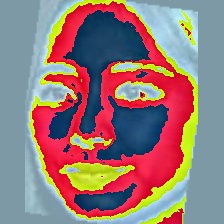

In [ ]:
print(np.shape(val_pairs[0, 0]))
cv2_imshow(val_pairs[0, 0])
# Images are fully preprocessed for Resnet50

#Training

In [ ]:
# Retrieves a weights from the weights folder of the given name and writes the weights
# to the passed model
def weight_fetch(file_name, model):
  path = '/content/Drive/MyDrive/EE443/FaceRec/Weights/' + file_name + '.h5'
  model.load_weights(path)
  return model

# Writes weights to a file in the Weights folder from the model
def weight_write(file_name, model):
  path = '/content/Drive/MyDrive/EE443/FaceRec/Weights/' + file_name + '.h5'
  model.save_weights(path)

In [ ]:
K.clear_session()
# Loads VGGFace Resnet50 model (pretrained on ImageNet and VGGFace datasets)
vggface_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

# Freezes Resnet50 weights so only added dense layers are trainable
vggface_model.trainable = False

# Defines inputs for each face in a pair
face1_input = Input(shape=(224, 224, 3))
face2_input = Input(shape=(224, 224, 3))

# Generates feature predictions from Resnet50 for each face
face1_features = vggface_model(face1_input)
face2_features = vggface_model(face2_input)

# Creates shared dense layers with dropout in between
 dense_layers = Dense(256, activation='relu')
 dropout = Dropout(0.2)
 dense_layers2 = Dense(128, activation='relu')

# Applies dense layers with dropout to both face features
face1_output = dense_layers(Flatten()(face1_features))
face1_output = dropout(face1_output)
face1_output = dense_layers2(face1_output)

face2_output = dense_layers(Flatten()(face2_features))
face2_output = dropout(face2_output)
face2_output = dense_layers2(face2_output)

# Calculates cosine distance between the dense outputs to generate an identity prediction
def cosine_distance(x):
    x1, x2 = x
    x1 = tf.math.l2_normalize(x1, axis=-1)
    x2 = tf.math.l2_normalize(x2, axis=-1)
    cosine = tf.reduce_sum(tf.multiply(x1, x2), axis=-1, keepdims=True)
    return cosine

cosine_distance_output = Lambda(cosine_distance)([face1_output, face2_output])

# Single node output layer
output = Dense(1, activation='sigmoid')(cosine_distance_output)

# Creates the model
verifyModel = Model(inputs=[face1_input, face2_input], outputs=output)

# Compiles the model with Adam optimizer and binary crossentropy loss
optimizer = Adam(learning_rate=.001)
verifyModel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Prints the model summaries
vggface_model.summary()
verifyModel.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

In [ ]:
# Will train the model on the training data saved to the disk, and will test the model after each epoch on the validation set. 
# Only the dense layer weights will be updated.
def train_face_verification_model(model, val_pairs, val_labels, epochs=10, batch_size=32):
    # Converts to numpy arrays
    val_pairs = np.array(val_pairs)
    val_labels = np.array(val_labels)

    # Training loop
    for epoch in range(epochs):
        print("Epoch", epoch+1)
        train_losses = []
        train_accuracies = []

        # Iterates through each set of data, loading and deloading them one at a time and randomizing the order within each set
        for i in range(1, 14):
            train_pairs = np.load('train_pairs_{}001.npy'.format(i))
            train_labels = np.load('train_labels_{}001.npy'.format(i))
            indices = np.arange(len(train_pairs))
            np.random.shuffle(indices)
            train_pairs = train_pairs[indices]
            train_labels = train_labels[indices]
            for j in range(0, len(train_pairs), batch_size):

                batch_pairs = train_pairs[j:j+batch_size]
                batch_labels = train_labels[j:j+batch_size]
                # Convert labels to appropriate data type
                batch_labels = batch_labels.astype(np.int32)

                # Train on batch
                history = model.train_on_batch([batch_pairs[:, 0], batch_pairs[:, 1]], batch_labels)
                # history = [loss, accuracy]
                train_accuracies.append(history[1]) 
                train_losses.append(history[0])

        train_accuracy = np.mean(train_accuracies)
        train_loss = np.mean(train_losses)
        # Evaluate on validation data and training data
        val_loss, val_accuracy = model.evaluate([val_pairs[:, 0], val_pairs[:, 1]], val_labels)
        print("Validation Loss:", val_loss, "Validation Accuracy:", val_accuracy)
        print("Training Loss:", train_loss, "Training Accuracy:", train_accuracy)
        weight_write('verifyModel{}'.format(epoch+1), model)
        
    return model

trained_model = train_face_verification_model(verifyModel, val_pairs, val_pair_labels, epochs=10, batch_size=64)

Epoch 1
4/4 [==============================] - 2s 118ms/step - loss: 0.6988 - accuracy: 0.5000
Validation Loss: 0.6988410353660583 Validation Accuracy: 0.5
Training Loss: 0.6919153145610484 Training Accuracy: 0.5327076651323002
Epoch 2
4/4 [==============================] - 1s 123ms/step - loss: 0.6667 - accuracy: 0.6600
Validation Loss: 0.666655957698822 Validation Accuracy: 0.6600000262260437
Training Loss: 0.6772982232239214 Training Accuracy: 0.5804775262360081
Epoch 3
4/4 [==============================] - 1s 122ms/step - loss: 0.6713 - accuracy: 0.5800
Validation Loss: 0.6713210344314575 Validation Accuracy: 0.5799999833106995
Training Loss: 0.6728424833494452 Training Accuracy: 0.591236510084349
Epoch 4
4/4 [==============================] - 1s 124ms/step - loss: 0.6684 - accuracy: 0.6000
Validation Loss: 0.6684337854385376 Validation Accuracy: 0.6000000238418579
Training Loss: 0.6654793646838099 Training Accuracy: 0.6116176330455215
Epoch 5
4/4 [==============================] 

In [ ]:
# Reload the weights from a saved file
#trained_model = weight_fetch('verifyModel', verifyModel)

#Testing

In [ ]:
# Tests the original, unchanged VGGface Resnet50 model to get a baseline score to compare with the modified model
def test_model(model, test_image_pairs, test_pair_labels):
    false_positives = 0
    false_negatives = 0
    true_positives = 0
    true_negatives = 0
    # Generates results from the model
    embeds1 = model.predict(test_image_pairs[:, 0])
    embeds2 = model.predict(test_image_pairs[:, 1])
    #results = vggFacePredsDoubles(test_image_pairs, model)
    # Counts the type of results
    results = []
    count = 0
    for i in range(len(embeds1)):
        results.append(verify(embeds1[i], embeds2[i], cutoff = 0.19))
    for i in range(len(results)):
        if test_pair_labels[i] == 1:
            count += 1
            if results[i] == 1:
                true_positives += 1
            else:
                false_negatives += 1
        else:
            if results[i] == 1:
                false_positives += 1
            else:
                true_negatives += 1
    print("The number of false positives is {}".format(false_positives))
    print("The number of false negatives is {}".format(false_negatives))
    print("The number of true positives is {}".format(true_positives))
    print("The number of true negatives is {}".format(true_negatives))
    print("Out of a total of {} image pairs".format(len(test_image_pairs)))
    print("Accuracy = {}".format((true_positives + true_negatives) / len(test_image_pairs)))
    print("Number of positive cases in set = {}".format(count))
    return np.array(results)
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
print(test_model(model, val_pairs, val_pair_labels))

4/4 [==============================] - 0s 64ms/step
The number of false positives is 25
The number of false negatives is 13
The number of true positives is 32
The number of true negatives is 30
Out of a total of 100 image pairs
Accuracy = 0.62
Number of positive cases in set = 45
[0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0
 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1]


In [ ]:
# Turns model outputs to prediction labels of 1 or 0
# Returns predicted label array
def generate_predictions(model, image_pairs):
    threshold = 0.5 #0.5 is used by default in model.evaluate
    outputs = model.predict([image_pairs[:, 0], image_pairs[:, 1]])
    outputs_binary = np.where(outputs >= threshold, 1, 0)
    return outputs_binary

In [ ]:
# Test a model on validation set
# Evaluation takes model output and applies threshold of 0.5
test_model = trained_model

val_loss, val_accuracy = test_model.evaluate([val_pairs[:, 0], val_pairs[:, 1]], val_pair_labels)
print("Validation Loss:", val_loss, "Validation Accuracy:", val_accuracy)

4/4 [==============================] - 1s 109ms/step - loss: 0.6126 - accuracy: 0.6900
Validation Loss: 0.6125831007957458 Validation Accuracy: 0.6899999976158142


In [ ]:
# Tests model on test set
test_model = trained_model

outputs_binary = generate_predictions(test_model, test_pairs)

# Saves output labels to a test file and assignes each label an id number
with open('testing.txt', 'w') as file:
    print("id, label", file=file)
    for i in range(len(outputs_binary)):
        print("{}. {}".format(i+1, str(outputs_binary[i])[1]), file=file)

13/13 [==============================] - 2s 143ms/step


4/4 [==============================] - 2s 156ms/step


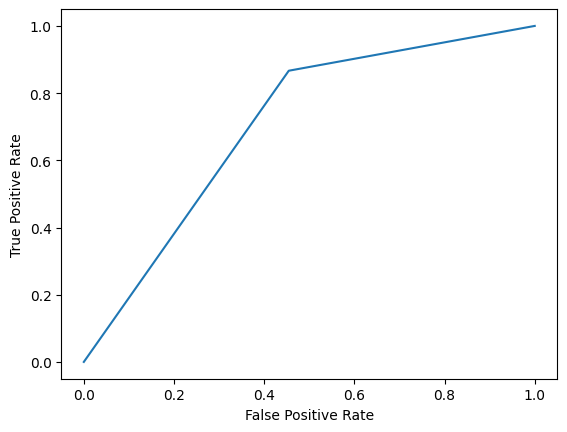

AUC value: 0.706060606060606


In [ ]:
# Function to plot the Reciever Operatinc Characteristic (ROC) and get the
# Area Under Curve (AUC).
# Use to compare the True Positive Rate (TPR, higher is good) and the False 
# Positive Rate (FPR, lower is good). The higher the AUC the better.

# Note: Comparing the TPR and FPR is good since a False Positive is more
# problematic than a False Negative in Face Verification.
def roc_auc_metric(y_test, y_pred):
    # Get the false positive rate and true positive rates
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)

    # Create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # Calculating the AUC value
    auc = roc_auc_score(y_test, y_pred)

    # Printing the AUC value
    print("AUC value:", auc)

validation_preds = generate_predictions(test_model, val_pairs)
roc_auc_metric(val_pair_labels, validation_preds)